# Water Scarcity and Global Conflict Analysis
This project aims to explore the complex relationship between armed conflict and water scarcity by integrating and analyzing datasets from various sources. We will leverage geospatial and environmental data to assess how water scarcity influences the occurrence and intensity of conflicts.

## Hypothesis: Water is one of the most critical resources on the planet for human survival. When the demand for critical resources, such as water, exceeds the supply, the number of conflicts increases.

## Definitions
- Scarcity: Demand for a good or service is greater than the availability of the good or service (Oxford Languages).
- Supply: total freshwater resources available in cubic meters per person, per year (The ImpEE Project).
- Withdrawal: amount extracted for use by country (The ImpEE Project).
- Water Stress: ratio between total freshwater withdrawn (TFWW) and total renewable freshwater resources (TRWR). Water stress = TFWW / TRWR (Wikipedia).
- Water Scarcity: volume of fresh water available does not meet the per person per day recommendations for human health (University of Nottingham).er day

In [33]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from functools import partial, reduce

## Data Collection and Cleanup

### Collect csv files

In [34]:
# Collect water scarcity data from the Food and Agriculture Organization (FAO) https://data.apps.fao.org/aquastat/?lang=en
aqua_csv = pd.read_csv('Resources/AQUASTAT Dissemination System.csv')

# Collect international conflict data from the University of Alabama https://internationalconflict.ua.edu/data-download/
mie_csv = pd.read_csv('Resources/ua-mie-1.0.csv')
micnames = pd.read_csv('Resources/ua-micnames-1.0.csv')

# Collect country codes from Correlates of War (COW) https://correlatesofwar.org/data-sets/cow-country-codes-2/
COW_Country_Codes = pd.read_csv('Resources/COW-country-codes.csv')

# Collect crime datasets annually by country from World Bank Group's Data Bank https://databank.worldbank.org/reports.aspx
crime_csv = pd.read_csv('Resources/wbgroup_crime.csv')

# Collect political regime type data from Out World in Data https://ourworldindata.org/grapher/political-regime-fh
regimes_csv = pd.read_csv('Resources/political-regime-fh.csv')

# Collect per capita income by country from Our World in Data https://ourworldindata.org/grapher/gdp-per-capita-worldbank
per_capita_income_csv = pd.read_csv('Resources/gdp-per-capita-worldbank.csv')

### Cleanup the Militarized Interstate Events (MIE) csv file

In [35]:
# Copy the dataframe with only the columns we want 
mie_df = mie_csv[['styear', 'ccode1', 'eventnum', 'micnum', 'hostlev', 'ccode2']].copy()

# Create a dictionary for the country codes and their names and the confrontation codes and their name
code_to_country = pd.Series(COW_Country_Codes.StateNme.values, index=COW_Country_Codes.CCode).to_dict()
conflict_name = pd.Series(micnames.micname.values, index= micnames.micnum).to_dict()

# Map the country codes to their names from the dictionary and replace
mie_df['ccode1'] = mie_df['ccode1'].map(code_to_country)
mie_df['ccode2'] = mie_df['ccode2'].map(code_to_country)
mie_df['micnum'] = mie_df['micnum'].map(conflict_name)

# Rename columns headers
mie_df_clean = mie_df.rename(columns={'styear': 'Year',
                                'ccode1': 'Country',
                                'ccode2': 'Target Country',
                                'eventnum': 'Event Number',
                                'micnum': 'Conflict Name',
                                'hostlev': 'Hosility Level'
                                })
# Display the clean dataframe
mie_df_clean.head()

,Year,Country,Event Number,Conflict Name,Hosility Level,Target Country
0,1902,United States of America,1,Alaska Boundary Dispute (1902),3,United Kingdom
1,1913,Austria-Hungary,1,Serbian and Austro-Hungarian Fighting over Alb...,2,Yugoslavia
2,1946,Albania,2,British Attempts to Pass the Albanian Corfu Ch...,4,United Kingdom
3,1946,United Kingdom,3,British Attempts to Pass the Albanian Corfu Ch...,3,Albania
4,1946,United Kingdom,4,British Attempts to Pass the Albanian Corfu Ch...,3,Albania


### Cleanup Freedom Level of Countries csv

In [36]:
# Create dataframe for Freedom Level of Countries (0 - not free/1-partly free/2-free country)
# Drop code column
regimes_df = regimes_csv.drop(columns=["Code"])

# Rename Entity column to country
regimes_df = regimes_df.rename(columns={'Entity': 'Country',
                                        'Political regime': 'Freedom Level'})

# Replace country with dictionary values
regimes_df['Country'] = regimes_df['Country'].replace(code_to_country)

regimes_df.head()

,Country,Year,Freedom Level
0,Abkhazia,1997,0
1,Abkhazia,1998,0
2,Abkhazia,1999,0
3,Abkhazia,2000,0
4,Abkhazia,2001,0


### Cleanup Per Capita Income csv

In [40]:
# Create dataframe for Per Capita Income
# Drop code column
per_capita_df = per_capita_income_csv.drop(columns=["Code"])


# Rename GDP per capita column
per_capita_df = per_capita_df.rename(columns={'Entity': 'Country',
                                              'GDP per capita, PPP (constant 2017 international $)': 'Per Capita Income'})

# Replace country with dictionary values
per_capita_df['Country'] = per_capita_df['Country'].replace(code_to_country)

per_capita_df.head()

,Country,Year,Per Capita Income
0,Afghanistan,2002,1280.4631
1,Afghanistan,2003,1292.3335
2,Afghanistan,2004,1260.0605
3,Afghanistan,2005,1352.3207
4,Afghanistan,2006,1366.9932


### Cleanup the AQUASTAT csv file

In [11]:
# Copy the dataframe with only the columns we want 
aqua_df = aqua_csv[['Year', 'Area', 'Variable', 'Value', 'Unit']].copy()

# Rename column header
aqua_df = aqua_df.rename(columns={'Area': 'Country'})

# Replace country with dictionary values
aqua_df['Country'] = aqua_df['Country'].replace(code_to_country)

#### Create columns for all variables in the export and create a new dataframe with new column values

In [12]:
# Create dataframe for Human Capital Index (max value = 1)
hdi_df = aqua_df.loc[aqua_df['Variable'] == 'Human Development Index (HDI)']
hdi_df = hdi_df.rename(columns={'Value': 'HDI'}).drop(columns=['Variable', 'Unit'])

In [13]:
# Create dataframe for Pop Density (ppl/km2)
pop_dens_df = aqua_df.loc[aqua_df['Variable'] == 'Population density']
pop_dens_df = pop_dens_df.rename(columns={'Value': 'Pop Density'}).drop(columns=['Variable', 'Unit'])

In [14]:
# Create dataframe for Wtr Stress %
wstress_df = aqua_df.loc[aqua_df['Variable'] == 'SDG 6.4.2. Water Stress']
wstress_df = wstress_df.rename(columns={'Value': 'Wtr Stress'}).drop(columns=['Variable', 'Unit'])

In [15]:
# Create dataframe for Total exploitable water resources (1b m3/yr)
tw_res_df = aqua_df.loc[aqua_df['Variable'] == 'Total exploitable water resources']
tw_res_df = tw_res_df.rename(columns={'Value': 'Tot Wtr Resource'}).drop(columns=['Variable', 'Unit'])

In [16]:
# Create dataframe for Total freshwater withdrawal 1b m3/yr)
tfw_wdrl_df = aqua_df.loc[aqua_df['Variable'] == 'Total freshwater withdrawal']
tfw_wdrl_df = tfw_wdrl_df.rename(columns={'Value': 'FreshW Wdrl'}).drop(columns=['Variable', 'Unit'])

In [17]:
# Create dataframe for Total Population (1000ppl)
tpop_df = aqua_df.loc[aqua_df['Variable'] == 'Total population']
tpop_df = tpop_df.rename(columns={'Value': 'Total Population'}).drop(columns=['Variable', 'Unit'])

In [18]:
# Create dataframe for Total Water Withdrawl (ppl/km2)
twdrl_df = aqua_df.loc[aqua_df['Variable'] == 'Total water withdrawal']
twdrl_df = twdrl_df.rename(columns={'Value': 'Total Withdrawl'}).drop(columns=['Variable', 'Unit'])

In [19]:
# Create dataframe for Total water withdrawal per capita (m3/ppl/yr)
tw_wdrl_pc_df = aqua_df.loc[aqua_df['Variable'] == 'Total water withdrawal per capita']
tw_wdrl_pc_df = tw_wdrl_pc_df.rename(columns={'Value': 'Wtr Withdrawl'}).drop(columns=['Variable', 'Unit'])

In [20]:
# Make a list of dataframes
aqua_df_lst = [hdi_df, pop_dens_df, wstress_df, tw_res_df, tfw_wdrl_df, tpop_df, twdrl_df, tw_wdrl_pc_df]

# Create a clean dataframe for water data 
aqua_df_clean = reduce(lambda left,right: pd.merge(left,right,on=['Year', 'Country'],how='outer'), aqua_df_lst)

# Display the clean dataframe
aqua_df_clean.head()

,Year,Country,HDI,Pop Density,Wtr Stress,Tot Wtr Resource,FreshW Wdrl,Total Population,Total Withdrawl,Wtr Withdrawl
0,1967.0,Afghanistan,NaN,15.332583,NaN,NaN,NaN,10010.030,NaN,NaN
1,1967.0,Albania,NaN,74.171930,NaN,13.0,NaN,2132.443,NaN,NaN
2,1967.0,Algeria,NaN,5.414997,NaN,7.9,NaN,12897.115,NaN,NaN
3,1967.0,Andorra,NaN,33.500000,NaN,NaN,NaN,15.745,NaN,NaN
4,1967.0,Angola,NaN,4.674343,NaN,NaN,NaN,5827.503,NaN,NaN


### Cleanup World Bank Group Crime Datasets

#### Create columns for each series name in the export and create a dataframe with all

In [21]:
# Filter out the homicides per 100k people
hom_df = crime_csv.loc[crime_csv['Series Name'] == 'Intentional homicides (per 100,000 people)'].set_index('Country Name')

# Use stack to drop unused columns and transpose the date columns into one columns
hom_df = hom_df.drop(columns=['Series Name', 'Series Code', 'Country Code']).stack().reset_index()

# Rename the column headers
hom_df = hom_df.rename(columns={'Country Name': 'Country',
                               'level_1': 'Year',
                                0: 'Homicides'
                               }).replace('..', 0)

In [22]:
# Filter out the total number of battle related people deaths
btl_dth_df = crime_csv.loc[crime_csv['Series Name'] == 'Battle-related deaths (number of people)'].set_index('Country Name')

# Use stack to drop unused columnstranspose the date columns into one columns
btl_dth_df = btl_dth_df.drop(columns=['Series Name', 'Series Code', 'Country Code']).stack().reset_index()

# Rename the column headers and replace null values ".." with 0
btl_dth_df = btl_dth_df.rename(columns={'Country Name': 'Country',
                                        'level_1': 'Year',
                                        0: 'Battle Deaths'
                                       }).replace('..', 0)

In [23]:
# Filter out the total % of annual sales firm losses due to theft and vandalism
theft_df = crime_csv.loc[crime_csv['Series Name'] == 'Losses due to theft and vandalism (% of annual sales for affected firms)'].set_index(
                                                                                                                                'Country Name')

# Use stack to drop unused columns and transpose the date columns into one columns
theft_df = theft_df.drop(columns=['Series Name', 'Series Code', 'Country Code']).stack().reset_index()

# Rename the column headers
theft_df = theft_df.rename(columns={'Country Name': 'Country',
                                        'level_1': 'Year',
                                        0: 'Theft & Vandalism'
                                       }).replace('..', 0)

In [24]:
# Make a list of dataframes
crime_df_lst = [hom_df, btl_dth_df, theft_df]

# Create a clean dataframe for water data 
crime_df_clean = reduce(lambda left,right: pd.merge(left,right,on=['Year', 'Country'],how='outer'), crime_df_lst)

# Replace country with dictionary values
crime_df_clean['Country'] = crime_df_clean['Country'].replace(code_to_country)

# Grab the first four values of the year column and convert to an integer
crime_df_clean['Year'] = crime_df_clean['Year'].str[0:4].astype(int)

# Display the clean dataframe
crime_df_clean.tail()

,Country,Year,Homicides,Battle Deaths,Theft & Vandalism
13295,West Bank and Gaza,2023,0,0,0
13296,World,2023,0,0,5.7
13297,"Yemen, Rep.",2023,0,0,0
13298,Zambia,2023,0,0,0
13299,Zimbabwe,2023,0,0,0


### Create Chart comparing the Freedom Level of Countries each year

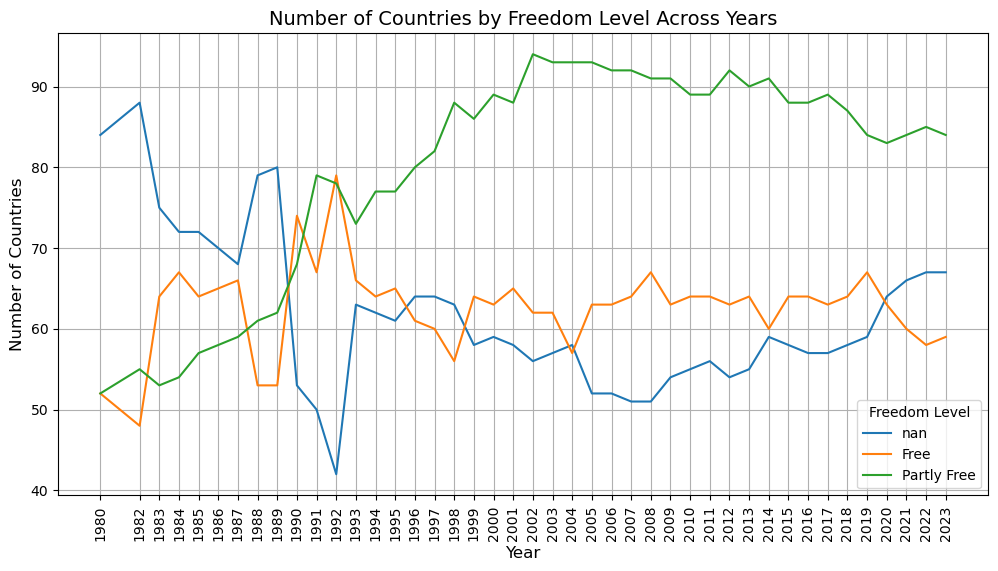

In [28]:
# Step 1: Define the mapping from numbers to words
freedom_level_mapping = {
    1: 'Free',
    2: 'Partly Free',
    3: 'Not Free'
}

# Filter the DataFrame to include only data from the year 1980 onwards
regimes_df_filtered = regimes_df[regimes_df['Year'] >= 1980]

# Group by 'Year' and 'Freedom Level' and count occurrences
freedom_counts = regimes_df_filtered.groupby(['Year', 'Freedom Level']).size().reset_index(name='Count')

# Pivot the data for easier plotting
pivot_df = freedom_counts.pivot(index='Year', columns='Freedom Level', values='Count').fillna(0)

# Step 2: Rename the columns using the mapping
pivot_df.columns = pivot_df.columns.map(freedom_level_mapping)

# Plotting
plt.figure(figsize=(12, 6))

# Plot lines for each Freedom Level
for freedom_level in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[freedom_level], label=freedom_level)

# Customizing the plot
plt.title('Number of Countries by Freedom Level Across Years', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Countries', fontsize=12)
plt.xticks(pivot_df.index, rotation=90)  # Set rotation to 90 degrees for vertical labels
plt.legend(title='Freedom Level')
plt.grid(True)
plt.show()


### Create Chart comparing the Per Capita income each year

### Create Master Dataframe with yearly data by country for analysis

In [45]:
# Merge aquastat and conflicts dataframes by year and country
aqua_mie_df = pd.merge(aqua_df_clean, mie_df_clean, how='outer', on=['Year', 'Country'])

# Merge aquastat and conflicts and crime dataframes by year and country
water_conflicts_df = pd.merge(aqua_mie_df, crime_df_clean, how='outer', on=['Year', 'Country'])

# merge with regime dataframe
water_conflicts_regimes_df = pd.merge(water_conflicts_df, regimes_df, how='outer', on=['Year', 'Country'])

# merge with per capita income dataframe
water_conflicts_final_df = pd.merge(water_conflicts_regimes_df, per_capita_df, how='outer', on=['Year', 'Country'])

# Fill the NaN under conflicts with no conflict
water_conflicts_final_df['Conflict Name'] = water_conflicts_final_df['Conflict Name'].fillna('No Conflict')
water_conflicts_final_df = water_conflicts_final_df.fillna(0)

# Display the final merged clean dataframe for analysis
water_conflicts_final_df.tail(5)

,Year,Country,HDI,Pop Density,Wtr Stress,Tot Wtr Resource,FreshW Wdrl,Total Population,Total Withdrawl,Wtr Withdrawl,Event Number,Conflict Name,Hosility Level,Target Country,Homicides,Battle Deaths,Theft & Vandalism,Freedom Level,Per Capita Income
54472,2023.0,World,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Conflict,0.0,0,0,0,5.7,0.0,0.0
54473,2023.0,Yemen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Conflict,0.0,0,0,0,0,0.0,0.0
54474,2023.0,"Yemen, Rep.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Conflict,0.0,0,0,0,0,0.0,0.0
54475,2023.0,Zambia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Conflict,0.0,0,0,0,0,1.0,0.0
54476,2023.0,Zimbabwe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Conflict,0.0,0,0,0,0,0.0,0.0


### Create a new csv file

In [ ]:
# Write the new merged dataframe to a csv file
water_conflicts_df.to_csv('Resources/water_conflicts_df.csv')